<a href="https://colab.research.google.com/github/akshgarg7/104_Project/blob/main/autoencoder_vs_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

11490434/11490434 [==============================] - 1s 0us/step


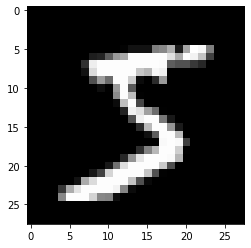

In [4]:
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

In [5]:
LATENT_SIZE = 32

In [6]:
encoder = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(64),
    LR(),
    Dropout(0.5),
    Dense(LATENT_SIZE),
    LR()
])

decoder = Sequential([
    Dense(64, input_shape = (LATENT_SIZE,)),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(28*28),
    Activation("sigmoid"),
    Reshape((28, 28))
])

In [7]:
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)


In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [9]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [15]:
model = Model(inputs = img, outputs = output)
model.compile(optimizer = "adam", loss = "mse")

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 sequential (Sequential)     (None, 32)                576480    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            577232    
                                                                 
Total params: 1,153,712
Trainable params: 1,153,712
Non-trainable params: 0
_________________________________________________________________


In [17]:
EPOCHS = 10

In [18]:
%matplotlib inline

1/1 [==============================] - 0s 13ms/step


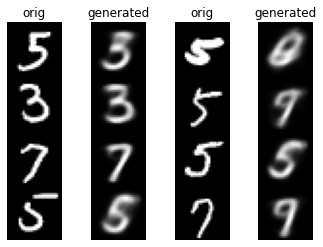

----------- EPOCH 9 -----------
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0441


In [19]:
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(0,4,2):
            axs[i, j].imshow(rand[i, j][0], cmap = "gray")
            axs[i, j+1].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
            axs[i, j+1].axis("off")
            if i < 1:
              axs[i,j].set_title('orig')
              axs[i,j+1].set_title('generated')

    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


In [20]:
# perform an SVD on the image to reduce it's dimensions
def SVD(img):
  U, s, V = np.linalg.svd(img)
  width, height = img.shape
  orig_space = width * height
  approximations = {}
  savings_dict = {}

  # low rank approximation of images using svd
  def low_rank_approximation(U, s, V, k):
      s_copy = s.copy()
      s_copy[k:] = 0
      return np.dot(U, np.dot(np.diag(s_copy), V))

  for k in [1, 2, 3, 4, 5,10, 15, 20, 25, 28]:
      space_used = width * k + k + k * height
      savings = round(100 - (space_used * 100 / orig_space), 4)
      results = low_rank_approximation(U, s, V, k)
      approximations[k] = results
      savings_dict[k] = savings
      
  return approximations, savings_dict


    

1/1 [==============================] - 0s 20ms/step


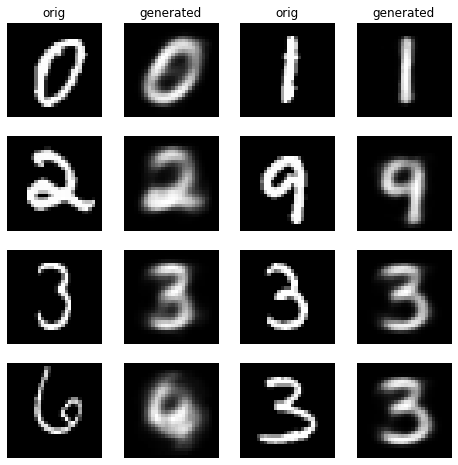

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)        
rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
display.clear_output() # If you imported display from IPython
fig, axs = plt.subplots(4, 4)
images = {"approximations": [], "savings": []}
for i in range(4):
  for j in range(0,4,2):
    img = rand[i, j]
    approx, savings = SVD(img[0])
    images['approximations'].append(approx)
    images['savings'].append(savings)
    axs[i, j].imshow(rand[i, j][0], cmap = "gray")
    axs[i, j+1].imshow(model.predict(rand[i, j])[0], cmap = "gray")
    axs[i, j].axis("off")
    axs[i, j+1].axis("off")
    if i < 1:
      axs[i,j].set_title('orig')
      axs[i,j+1].set_title('generated')


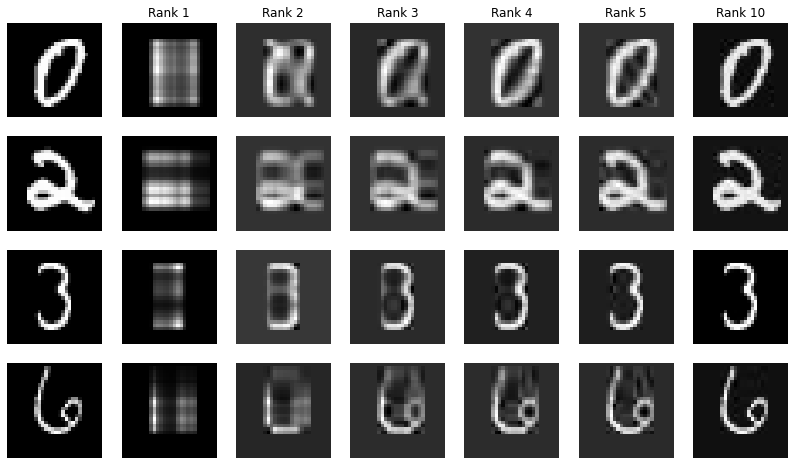

In [22]:
plt.rcParams["figure.figsize"] = (14,8)        
fig, axs = plt.subplots(4, 7)
for i in range(4):
    for j in range(7):
        axs[i, j].axis("off")
    for j in range(0,2,2):
        img = rand[i, j][0]
        approx, savings = SVD(img)
        axs[i,0].imshow(img, cmap='gray')
        axs[i,1].imshow(approx[1], cmap='gray')
        axs[i,2].imshow(approx[2], cmap='gray')
        axs[i,3].imshow(approx[3], cmap='gray')
        axs[i,4].imshow(approx[4], cmap='gray')
        axs[i,5].imshow(approx[5], cmap='gray')
        axs[i,6].imshow(approx[10], cmap='gray')
        if i == 0:
          axs[i,1].set_title(f"Rank {1}")
          axs[i,2].set_title(f"Rank {2}")
          axs[i,3].set_title(f"Rank {3}")
          axs[i,4].set_title(f"Rank {4}")
          axs[i,5].set_title(f"Rank {5}")
          axs[i,6].set_title(f"Rank {10}")
      
        

In [23]:
model.save('32.h')

In [24]:
load = tf.keras.models.load_model('32.h')

1/1 [==============================] - 0s 27ms/step


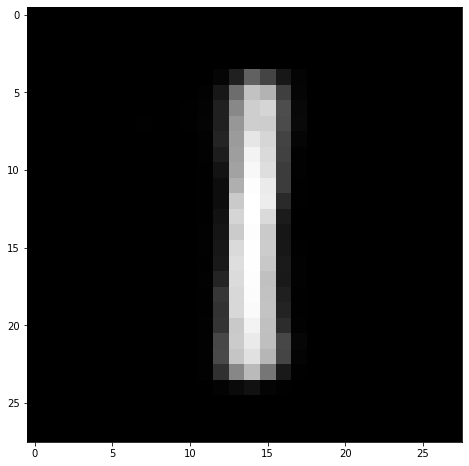

In [28]:
plt.imshow(load.predict(rand[0,2])[0], cmap='gray')